In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], [
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 512 * 1)
        ]
    )

In [4]:
print ('TF Version :', tf.__version__)

TF Version : 2.7.0


### Utility Function

In [5]:
def __func_plot(title, dataset, list_of_index=None):
    
    # random index of dataset
    if list_of_index == None:
        list_of_index = np.random.randint(dataset.shape[0], size=4).tolist()
    
    # set figure
    plt.figure(figsize=(16, 2))
    
    for c, i in enumerate(list_of_index):
        
        # subplot
        ax = plt.subplot(1, len(list_of_index), c + 1)
        ax.set_ylim([0., 1.])
        
        # plot
        plt.gray()
        plt.title(title)
        plt.plot(np.arange(dataset.shape[1]), dataset[i], scaley=True)
    
    # show
    plt.show()

def __func_plot_cpmpare(title, dataset1, dataset2, list_of_index=None):
    
    # random index of dataset
    if list_of_index == None:
        list_of_index = np.random.randint(dataset1.shape[0], size=4).tolist()
    
    # set figure
    plt.figure(figsize=(16, 2))
    
    for c, i in enumerate(list_of_index):
        
        # subplot
        ax = plt.subplot(1, len(list_of_index), c + 1)
        ax.set_ylim([0., 1.])
        
        # plot
        plt.plot(dataset1[i], 'b')
        plt.plot(dataset2[i], 'r')
        
        plt.fill_between(np.arange(dataset1.shape[1]), dataset1[i], dataset2[i], color='lightcoral')
        plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    
    # show
    plt.show()

# 1. Setup Dataset

In [6]:
# Download Dataset
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

# Get (Data, Label)
x = df.iloc[:, :-1].values
y = df.iloc[:,  -1].values

# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
# Get Max/Min Value
min_value = np.min(x_train)
max_value = np.max(x_train)

# Normalization Dataset -> [0, 1]
x_train = (x_train - min_value) / (max_value - min_value)
x_test  = (x_test  - min_value) / (max_value - min_value)

In [8]:
# Convert (0, 1) -> (False, True)
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# filter only normal
x_train_normal = x_train[y_train]
x_test_normal = x_test[y_test]

# filter only anomalous
x_train_anomalous = x_train[~y_train]
x_test_anomalous = x_test[~y_test]

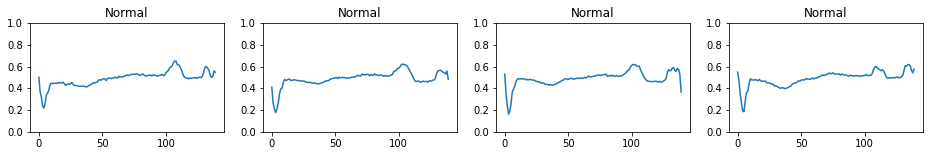

In [9]:
# Dataset Plot
__func_plot('Normal', x_train_normal)

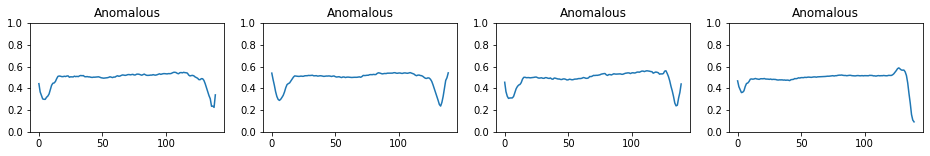

In [10]:
# Dataset Plot
__func_plot('Anomalous', x_train_anomalous)

# 2. Setup Model

#### - Free Memory

In [11]:
tf.keras.backend.clear_session()

#### - Autoencoder

In [12]:
# inputs
inputs = Input(shape=(140), name='Inputs')

# layers
layers = Dense(64, activation='relu', name='Encoder-1')(inputs)
layers = Dense(32, activation='relu', name='Encoder-2')(layers)
layers = Dense(16, activation='relu', name='latents'  )(layers)
layers = Dense(32, activation='relu', name='Decoder-1')(layers)
layers = Dense(64, activation='relu', name='Decoder-2')(layers)

# outputs
outputs = Dense(140, activation='sigmoid', name='Outputs')(layers)

# model
autoencoder = Model(inputs, outputs, name='Autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 140)]             0         
                                                                 
 Encoder-1 (Dense)           (None, 64)                9024      
                                                                 
 Encoder-2 (Dense)           (None, 32)                2080      
                                                                 
 latents (Dense)             (None, 16)                528       
                                                                 
 Decoder-1 (Dense)           (None, 32)                544       
                                                                 
 Decoder-2 (Dense)           (None, 64)                2112      
                                                                 
 Outputs (Dense)             (None, 140)               

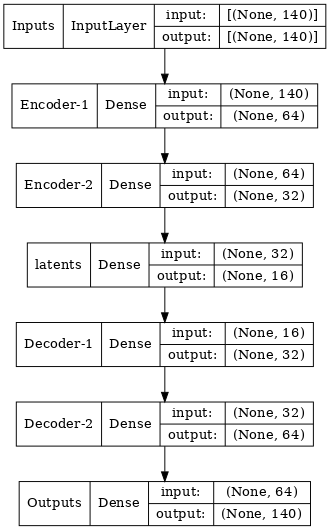

In [13]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=69)

# 3. Model Training

In [14]:
# model fit
history = autoencoder.fit(x_train_normal, x_train_normal, epochs=40, validation_split=0.2)

Epoch 1/40
58/58 [==============================] - 2s 8ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 2/40
58/58 [==============================] - 0s 5ms/step - loss: 9.5168e-04 - val_loss: 0.0011
Epoch 3/40
58/58 [==============================] - 0s 4ms/step - loss: 9.2588e-04 - val_loss: 0.0010
Epoch 4/40
58/58 [==============================] - 0s 4ms/step - loss: 8.4726e-04 - val_loss: 8.2707e-04
Epoch 5/40
58/58 [==============================] - 0s 7ms/step - loss: 6.8947e-04 - val_loss: 6.2603e-04
Epoch 6/40
58/58 [==============================] - 0s 4ms/step - loss: 5.1258e-04 - val_loss: 4.9666e-04
Epoch 7/40
58/58 [==============================] - 0s 4ms/step - loss: 4.4439e-04 - val_loss: 4.6661e-04
Epoch 8/40
58/58 [==============================] - 0s 3ms/step - loss: 4.3386e-04 - val_loss: 4.5002e-04
Epoch 9/40
58/58 [==============================] - 0s 4ms/step - loss: 4.2251e-04 - val_loss: 4.4547e-04
Epoch 10/40
58/58 [==============================] - 0s 3ms/st

<AxesSubplot:>

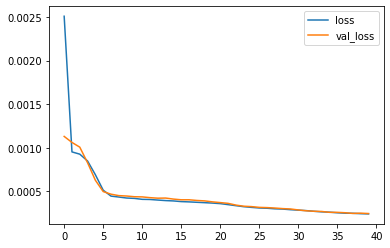

In [15]:
# model performance
pd.DataFrame(autoencoder.history.history).plot()

# 4. Model Evaluation

#### - Normal

In [16]:
# model predict
y_pred_normal = autoencoder.predict(x_test_normal)

In [17]:
# get list_of_index
list_of_index = np.random.randint(x_test_normal.shape[0], size=4).tolist()

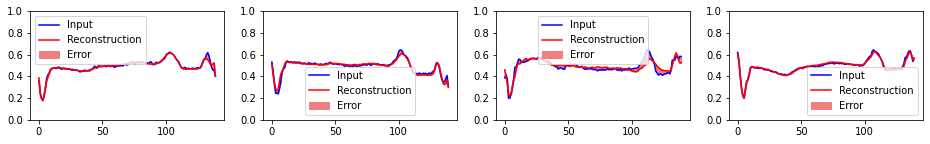

In [18]:
__func_plot_cpmpare('Test\nNormal', x_test_normal, y_pred_normal, list_of_index)

#### - anomalous

In [19]:
# model predict
y_pred_anomalous = autoencoder.predict(x_test_anomalous)

In [20]:
# get list_of_index
list_of_index = np.random.randint(x_test_anomalous.shape[0], size=4).tolist()

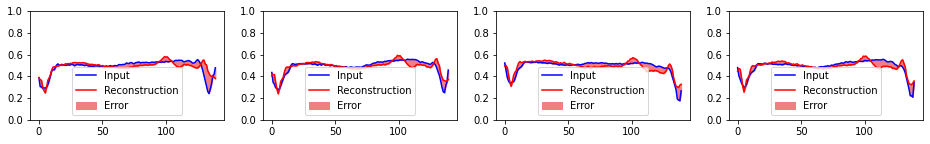

In [21]:
__func_plot_cpmpare('Test\nAnomalous', x_test_anomalous, y_pred_anomalous, list_of_index)